In [4]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

from datetime import date,timedelta, datetime

import sqlite3

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,recall_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense, LSTM

import investpy
from ta import add_all_ta_features



In [ ]:
today = date.today()
timestamp = datetime.now()

In [5]:
# BTC
data = investpy.get_crypto_historical_data(crypto='bitcoin', from_date=("02/03/2022"), to_date=today.strftime("%d/%m/%Y"))
# MANA
# data = investpy.get_crypto_historical_data(crypto='decentraland', from_date=("02/03/2022"), to_date=today.strftime("%d/%m/%Y"))

data=data.drop(['Currency'],axis=1)

# Add RSI indicator
from ta.momentum import RSIIndicator
rsiindicator = RSIIndicator(close = data.Close, fillna=True)
data["RSI"] = rsiindicator.rsi()

# Add RSI indicator
from ta.momentum import stochrsi
data["Stochrsi"] = stochrsi(data.Close, fillna=True)

# Add MACD indicator
from ta.trend import macd
data["MACD"] = macd(data.Close,fillna=True)


from ta.trend import sma_indicator
data["SMA"] = sma_indicator(data.Close, fillna=True)

# Add Bollinger Band high indicator
from ta.volatility import BollingerBands
# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=data["Close"])
data['BB_BBH'] = indicator_bb.bollinger_hband_indicator()
data


# NUESTROS DATOS

# Conexión a la bbdd de pln
conn1=sqlite3.connect('rrss ampliado.db')
c1=conn1.cursor()

df_pol = pd.read_sql_query("SELECT DATETIME(strftime('%Y-%m-%d',a.fecha)) as fecha_cambiada,avg(b.polaridad) as pol FROM PRINCIPAL a inner join PNL b ON a.id_post=b.id_post group by fecha_cambiada ORDER BY fecha_cambiada asc;", conn1)
df_pol=df_pol.head(len(data))

# Cierre de conexión
c1.close()
conn1.close()



# Conexión a la bbdd de pytrends
conn1=sqlite3.connect('pytrends.db')
c1=conn1.cursor()

df_pytrends = pd.read_sql_query("SELECT strftime('%Y-%m-%d',a.fecha) as fecha_cambiada,sum(busquedas)/4 as busquedas FROM PRINCIPAL_G a inner join INCLUIDO_G b ON a.id_principalg=b.id_principalg WHERE b.id_topicg in (1,2,5,6) group by fecha_cambiada order by fecha_cambiada asc;", conn1)
df_pytrends.drop(df_pytrends.head(1).index,inplace=True)
df_pytrends=df_pytrends.head(len(data))

# Cierre de conexión
c1.close()
conn1.close()


# Polaridad
data['polaridad']=df_pol['pol'].tolist()
# Volumen búsquedas de Google
data['pytrends']=df_pytrends['busquedas'].tolist()


data.head()

,Open,High,Low,Close,Volume,RSI,Stochrsi,MACD,SMA,BB_BBH,polaridad,pytrends
Date,,,,,,,,,,,,
2022-03-02,44420.3,45294.2,43361.3,43912.8,80819,100.000000,0.0,0.000000,43912.800,0.0,0.000000,1641
2022-03-03,43912.8,44077.2,41840.8,42463.0,74110,0.000000,0.0,-115.653561,43187.900,0.0,-0.226562,1489
2022-03-04,42463.0,42848.7,38594.9,39142.7,3206467584,0.000000,0.0,-469.814573,41839.500,0.0,0.107000,1491
2022-03-05,39142.8,39600.2,38626.1,39395.8,1495417216,5.518588,0.0,-721.746823,41228.575,0.0,-0.050000,1352
2022-03-06,39396.3,39668.1,38115.0,38403.1,1926309760,4.475385,0.0,-990.094349,40663.480,0.0,0.090969,1332


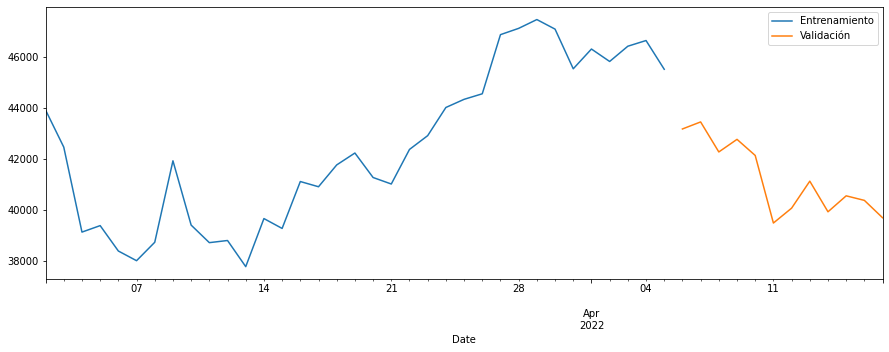

In [6]:
# Sets de entrenamiento y validación 
# Se decide que el 20% de la muestra final se dedique a la validación y el resto para entrenar

p_train=0.75

set_entrenamiento = data[:int((len(data))*p_train)]
set_validacion = data[int((len(data))*p_train):]

plt.figure(figsize=(15,5))
set_entrenamiento['Close'].plot(legend=True)
set_validacion['Close'].plot(legend=True)
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

In [7]:
set_entrenamiento.describe()

,Open,High,Low,Close,Volume,RSI,Stochrsi,MACD,SMA,BB_BBH,polaridad,pytrends
count,35.000000,35.000000,35.000000,35.000000,3.500000e+01,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,42452.457143,43422.000000,41570.594286,42482.808571,1.315526e+09,47.357879,0.501752,-111.364955,41758.497900,0.085714,0.094116,1490.028571
std,3100.262238,3057.067182,3154.123515,3125.689743,1.241146e+09,23.547933,0.451769,1025.308371,2210.663764,0.284029,0.065871,190.087516
min,37789.500000,39272.300000,37182.100000,37792.400000,7.411000e+04,0.000000,0.000000,-1394.663148,39112.516667,0.000000,-0.226562,1166.000000
25%,39409.400000,40791.500000,38614.800000,39406.050000,4.138645e+08,35.508562,0.000000,-1094.417054,40025.545833,0.000000,0.100714,1316.500000
50%,42241.000000,42848.700000,40922.000000,42233.000000,5.370561e+08,53.256485,0.466832,-349.890478,40765.066667,0.000000,0.108817,1512.000000
75%,45035.500000,46813.500000,44353.000000,45515.500000,2.284180e+09,62.560037,1.000000,976.502460,43551.808333,0.000000,0.114951,1612.000000
max,47449.000000,48199.000000,47029.000000,47449.000000,4.468697e+09,100.000000,1.000000,1433.745110,46128.500000,1.000000,0.145201,1820.000000


In [8]:
set_validacion.describe()

,Open,High,Low,Close,Volume,RSI,Stochrsi,MACD,SMA,BB_BBH,polaridad,pytrends
count,12.000000,12.000000,12.000000,12.000000,1.200000e+01,12.000000,12.000000,12.000000,12.000000,12.0,12.000000,12.000000
mean,41740.833333,42322.166667,40747.750000,41257.500000,3.584373e+08,40.897569,0.106361,-174.018093,43876.750000,0.0,0.111543,1269.500000
std,1787.380706,1615.941259,1504.408801,1429.511264,1.671296e+08,3.804224,0.104359,670.738165,1653.013248,0.0,0.008458,416.957268
min,39507.000000,40599.000000,39202.000000,39497.000000,1.513136e+08,33.633558,0.000000,-958.696727,41257.500000,0.0,0.096898,61.000000
25%,40304.500000,40810.250000,39576.000000,40042.500000,2.273182e+08,38.110628,0.000000,-757.263526,42627.104167,0.0,0.107333,1216.750000
50%,41638.500000,41966.500000,39892.000000,40846.500000,3.425696e+08,41.435247,0.082661,-366.589489,43895.791667,0.0,0.109781,1341.000000
75%,42861.500000,43539.000000,42117.000000,42398.000000,4.679428e+08,42.733454,0.172337,347.404523,45287.208333,0.0,0.115651,1476.000000
max,45494.000000,45519.000000,43122.000000,43448.000000,6.495240e+08,46.748376,0.278235,957.162217,46032.000000,0.0,0.127743,1719.000000


In [9]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [10]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a partir de esos "time_step" datos).
# Se conformará de esta forma el set de entrenamiento
time_step = 1
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [11]:
# Red LSTM
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
history = modelo.fit(X_train,Y_train,epochs=50,batch_size=2,validation_split=0.1)


Epoch 1/50
15/15 [==============================] - 6s 90ms/step - loss: 0.2383 - val_loss: 0.6204
Epoch 2/50
15/15 [==============================] - 0s 8ms/step - loss: 0.1837 - val_loss: 0.5089
Epoch 3/50
15/15 [==============================] - 0s 8ms/step - loss: 0.1479 - val_loss: 0.4188
Epoch 4/50
15/15 [==============================] - 0s 7ms/step - loss: 0.1191 - val_loss: 0.3401
Epoch 5/50
15/15 [==============================] - 0s 9ms/step - loss: 0.0940 - val_loss: 0.2579
Epoch 6/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0757 - val_loss: 0.2055
Epoch 7/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0662 - val_loss: 0.1699
Epoch 8/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0583 - val_loss: 0.1351
Epoch 9/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0524 - val_loss: 0.1072
Epoch 10/50
15/15 [==============================] - 0s 7ms/step - loss: 0.0491 - val_loss: 0.0878
Epoch 11/50
15/15 

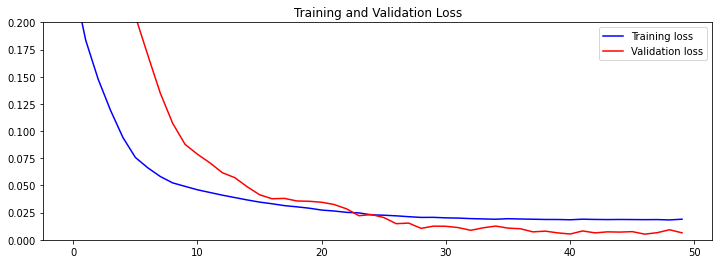

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(12,4))
plt.ylim(0,0.2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [13]:
inputs = sc.transform(set_validacion) 


In [14]:

X_test = []
Y_test = []
for i in range(time_step,len(inputs)):
    X_test.append(inputs[i-time_step:i,0])
    Y_test.append(inputs[i, 0])
X_test,Y_test  = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [15]:
Y_pred = modelo.predict(X_test)

In [16]:
a=sc.scale_
a

array([1.03525027e-04, 1.12023480e-04, 1.01554804e-04, 1.03556117e-04,
       2.23782610e-10, 1.00000000e-02, 1.00000000e+00, 3.53555749e-04,
       1.42531695e-04, 1.00000000e+00, 2.68988242e+00, 1.52905199e-03])

In [17]:
scale = 1/a[0]

In [18]:
Y_pred = Y_pred*scale

In [19]:
Y_test = Y_test*scale

In [20]:
Y_pred.shape

(11, 1)

In [21]:
data_pred=pd.DataFrame(columns=['Real','Pred'])
data_pred['Real']=set_validacion['Close']
Y_pred=np.insert(Y_pred,0,0)
data_pred['Pred']=Y_pred

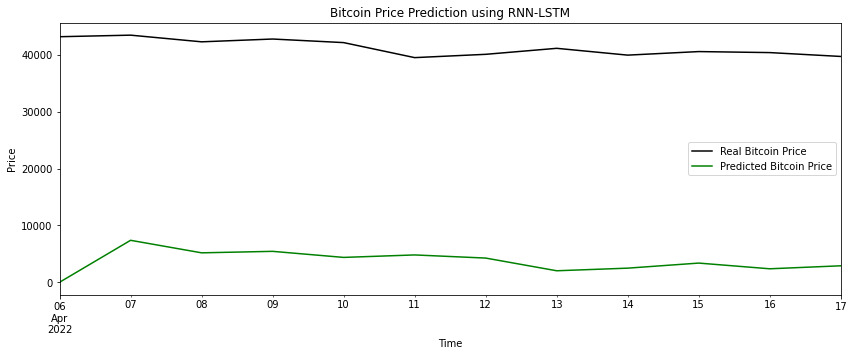

In [22]:
plt.figure(figsize=(14,5))
data_pred['Real'].plot(color = 'black', label = 'Real Bitcoin Price')
data_pred['Pred'].plot(color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [23]:
data_pred['dif_real']=data_pred['Real'].diff().fillna(0)
data_pred['dif_predict'] = data_pred['Pred'].diff().fillna(0)

In [24]:
data_pred['bin_up_true']=data_pred['dif_real'].apply(lambda x: 1 if x>0  else 0)
data_pred['bin_up_predict']=data_pred['dif_predict'].apply(lambda x: 1 if x>0  else 0)

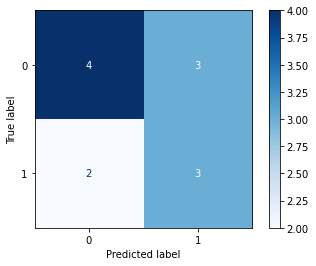

In [25]:
cm1=confusion_matrix(data_pred['bin_up_true'],data_pred['bin_up_predict'])
cm_display1 = ConfusionMatrixDisplay(cm1,display_labels=[0,1]).plot(cmap=plt.cm.Blues,values_format='.0f')

In [26]:
accuracy_score(data_pred['bin_up_true'],data_pred['bin_up_predict'])*100

58.333333333333336

In [27]:
f1_score(data_pred['bin_up_true'],data_pred['bin_up_predict'])*100

54.54545454545454

In [28]:
recall_score(data_pred['bin_up_true'],data_pred['bin_up_predict'])*100

60.0

In [ ]:
# # Importación a la bbdd
# import sqlite3
# conn = sqlite3.connect('red_mana.db')
# c = conn.cursor()
 
# conn.commit()

# precio=data['Close'].iloc[-1]
# ult_precio=c.execute("""SELECT precio FROM RED ORDER BY rowid DESC LIMIT 1; """).fetchone()
# if ult_precio[0]<precio:
#     realidad=1
# else:
#     realidad=0

# try:
#     c.execute("""UPDATE RED SET realidad = (?) WHERE rowid = (SELECT MAX(rowid) FROM RED)""",(realidad,))
# except sqlite3.Error as error:
#     print("No se ha podido meter los datos de realidad:", error)
#     conn.commit()


# id=1
# predic=data['bin_up_predict_2'].iloc[-1]
# accuracy=accuracy_score(data['bin_up_true'][date_i:], data['bin_up_predict_2'][date_i:])*100
# recall=recall_score(data['bin_up_true'][date_i:], data1['bin_up_predict_2'][date_i:])*100
# f1=f1_score(data['bin_up_true'][date_i:], data['bin_up_predict_2'][date_i:])*100

# try:
#     query="""INSERT INTO RED(id_cripto, timestamp, precio, prediccion, accuracy, recall, f1) VALUES (?, ?, ?, ?, ?, ?, ?);"""
#     insertar= (id, timestamp, precio, int(predic), accuracy, recall, f1)
#     c.execute(query, insertar)
#     conn.commit()
# except sqlite3.Error as error:
#     print("No se ha podido meter los datos:", error)
    
# c.close()
# conn.close()

In [29]:
# ###  INSERTA DATAFRAME EN LA BASE DE DATOS DE LAS VARIABLES FINANCIERAS####
# import sqlite3
# conexion= sqlite3.connect('rrss ampliado.db')
# #Creamos el cursor.
# cursor = conexion.cursor()

# #Insertamos el dataframe a su correspondiente tabla.

# #Tabla PLN
# data.to_sql("VAR_FIN",con=conexion, if_exists='replace')

# # df1.to_sql("PALABRAS", con=conexion, if_exists='replace')

# # conexion.execute("SELECT * FROM PNL").fetchall()
# conexion.commit()

# #cerramos la conexion 
# conexion.close()